In [1]:
# Import packages

import matplotlib.pyplot as plt
import copy

from climada.entity import Entity
from climada.util.constants import ENT_DEMO_TODAY, ENT_DEMO_FUTURE, HAZ_DEMO_H5
from climada.hazard import Hazard

import functions as fcn



In [2]:
# Parameters
YEAR_START = 2020
YEAR_FUTURE = 2050

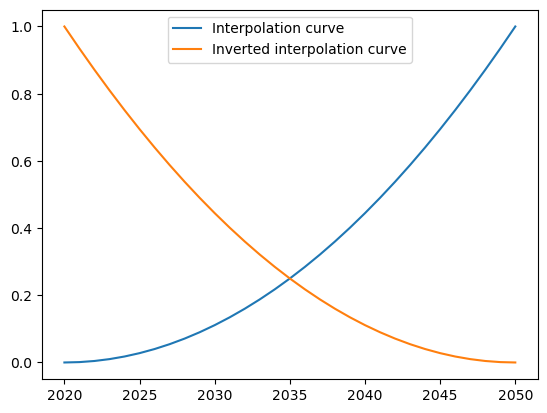

In [3]:
# Show the interpolation curve
x_range = [YEAR_START, YEAR_FUTURE]
y_range = [0, 1]
param = 2
curve_list, curve_dict, curve_invrt, curve_invrt_dict = fcn.interpolate_curve(x_range, y_range, param)
plt.plot(range(x_range[0], x_range[1]+1), curve_list, label='Interpolation curve')
plt.plot(range(x_range[0], x_range[1]+1), curve_invrt, label='Inverted interpolation curve')
plt.legend()

In [1]:
# Genereta the Exposure per year using either interpolation and extrapolation
# Later add a blue marker showing values given in the exp_dict

from functions import exp_expnl_growth

# Parameters
# Input to function
exp_dict = {YEAR_START: Entity.from_excel(ENT_DEMO_TODAY).exposures}
exp_dict[YEAR_FUTURE] = Entity.from_excel(ENT_DEMO_TODAY).exposures
exp_dict[YEAR_FUTURE].gdf.value *= (1+0.02)**(YEAR_FUTURE-YEAR_START)
# Interpolation parameter
intr_param = 2
# Extraolation function and end year
extra_func = lambda exp_dict, year: exp_expnl_growth(exp_dict, year, growth_rate=0.02) # Needs to be a function that takes exp_dict and year as input and returns an Entity

# Generate the exposure per year dictionary
exp_per_year_dict = fcn.generate_exp_per_year(exp_dict, intr_param, extra_func, YEAR_FUTURE)

NameError: name 'YEAR_START' is not defined

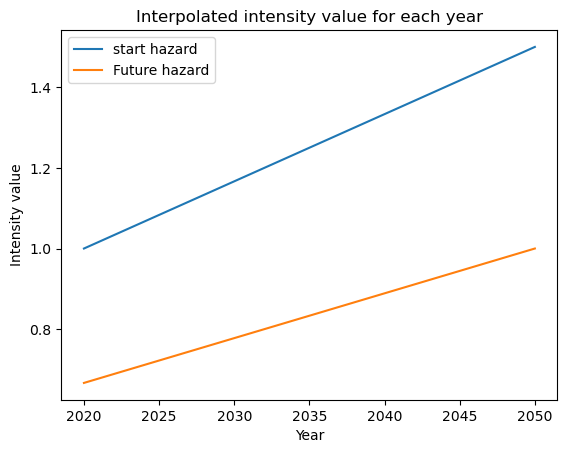

In [5]:
# Generate the hazard sets for each year

from functions import haz_growth

# start hazard
haz_sets_dict = {YEAR_START: Hazard.from_hdf5(HAZ_DEMO_H5)}
# Future hazard
haz_sets_dict[YEAR_FUTURE] = Hazard.from_hdf5(HAZ_DEMO_H5)
haz_sets_dict[YEAR_FUTURE].intensity *= 1.5

# Interpolation parameters
freq_intr_param = 1  # Frequency interpolation parameter
intens_intr_param = 1 # Intensity interpolation parameter

# Extraolation function and end year
haz_growth_fnc = lambda haz_sets_dict, year: haz_growth(haz_sets_dict, year, year_future=YEAR_FUTURE, inten_multi=1.5, freq_multi=2, intr_param=1)

# Interpolation parameters
freq_intr_param = 1  # Frequency interpolation parameter
intens_intr_param = 1 # Intensity interpolation parameter
# Test the function
haz_sets_per_year_dict = fcn.generate_haz_sets_per_year(haz_sets_dict, freq_intr_param, YEAR_FUTURE, haz_growth_fnc, intens_intr_param)

In [6]:
# Create the impact function set per year

imp_fun_set_per_year = {} 

for year in range(YEAR_START, YEAR_FUTURE+1):
    imp_fun_set_per_year[year] = Entity.from_excel(ENT_DEMO_TODAY).impact_funcs

In [7]:
# Calculate the impact per year 

imp_objs_per_year_dict, rel_imp_objs_per_year_dict = fcn.generate_imp_objs_per_year(haz_sets_per_year_dict, exp_per_year_dict, imp_fun_set_per_year, YEAR_START, YEAR_FUTURE)

In [8]:
# Create the events per year dictionary

# Parameters
n_samples = 1000

events_ids_per_year_dict = fcn.generate_event_ids_per_year(rel_imp_objs_per_year_dict, n_samples, YEAR_START, YEAR_FUTURE)

In [9]:
#%% Calculate the impacts per year

abs_impact_per_year_dict, abs_impact_per_exp_year_dict = fcn.generate_imp_per_year(events_ids_per_year_dict, rel_imp_objs_per_year_dict, exp_per_year_dict, YEAR_START, YEAR_FUTURE)

In [10]:
# Compare the reults to using the poison yearssets

comp_abs_impact_per_year_dict = fcn.generate_imp_per_year_using_yearsets(events_ids_per_year_dict, imp_objs_per_year_dict, YEAR_START, YEAR_FUTURE)

In [11]:
# Compare the results using the two methods and print the differences

diff_dict = {}
for key in comp_abs_impact_per_year_dict.keys():
    diff_dict[key] = abs_impact_per_year_dict[key].compare(comp_abs_impact_per_year_dict[key])
    # print sums
    print(f'{key} with sums {abs_impact_per_year_dict[key].sum().sum()} vs {comp_abs_impact_per_year_dict[key].sum().sum()}')
    # print differences
    print(f'{key} with differences {abs_impact_per_year_dict[key].sum().sum() - comp_abs_impact_per_year_dict[key].sum().sum()}')

print(diff_dict)

TC with sums 18646928877641.02 vs 18646928877641.02
TC with differences 0.0
MULTI with sums 18646928877641.02 vs 18646928877641.02
MULTI with differences 0.0
{'TC':     2020       2021       2022                2023               2024        \
    self other self other self other          self         other self other   
1    NaN   NaN  NaN   NaN  NaN   NaN  1.302956e+09  1.302956e+09  NaN   NaN   
2    NaN   NaN  NaN   NaN  NaN   NaN  2.362702e+09  2.362702e+09  NaN   NaN   
4    NaN   NaN  NaN   NaN  NaN   NaN           NaN           NaN  NaN   NaN   
7    NaN   NaN  NaN   NaN  NaN   NaN           NaN           NaN  NaN   NaN   
8    NaN   NaN  NaN   NaN  NaN   NaN           NaN           NaN  NaN   NaN   
..   ...   ...  ...   ...  ...   ...           ...           ...  ...   ...   
993  NaN   NaN  NaN   NaN  NaN   NaN           NaN           NaN  NaN   NaN   
996  NaN   NaN  NaN   NaN  NaN   NaN           NaN           NaN  NaN   NaN   
997  NaN   NaN  NaN   NaN  NaN   NaN         